# Wavelet Learned Lossy Compression (WaLLoC)

WaLLoC sandwiches a convolutional autoencoder between time-frequency analysis and synthesis transforms using 
CDF 9/7 wavelet filters. The time-frequency transform increases the number of signal channels, but reduces the temporal or spatial resolution, resulting in lower GPU memory consumption and higher throughput. WaLLoC's training procedure is highly simplified compared to other $\beta$-VAEs, VQ-VAEs, and neural codecs, but still offers significant dimensionality reduction and compression. This makes it suitable for dataset storage and compressed-domain learning. It currently supports 2D signals (e.g. grayscale, RGB, or hyperspectral images). Support for 1D and 3D signals is in progress.

## Installation

1. Follow the installation instructions for [torch](https://pytorch.org/get-started/locally/)
2. Install WaLLoC and other dependencies via pip

```pip install walloc PyWavelets pytorch-wavelets```

## Pre-trained checkpoints

Pre-trained checkpoints are available on [Hugging Face](https://huggingface.co/danjacobellis/walloc).

## Training

Access to training code is provided by request via [email.](mailto:danjacobellis@utexas.edu)

## Usage example

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import display
from torchvision.transforms import ToPILImage, PILToTensor
from walloc.walloc import Walloc
class Args: pass

### Load the model from a pre-trained checkpoint

```wget https://hf.co/danjacobellis/walloc/resolve/main/v0.6.3_ext.pth```

In [2]:
device = "cpu"
checkpoint = torch.load("v0.6.3_ext.pth",map_location="cpu")
args = checkpoint['args']
codec = Walloc(
    channels = args.channels,
    J = args.J,
    N = args.N,
    latent_dim = args.latent_dim,
    latent_bits = 5
)
codec.load_state_dict(checkpoint['model_state_dict'])
codec = codec.to(device)

### Load an example image

```wget "https://r0k.us/graphics/kodak/kodak/kodim05.png"```

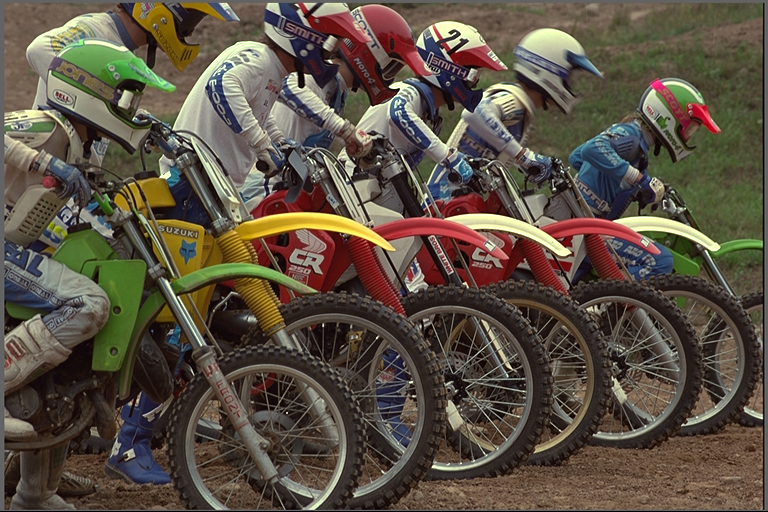

In [3]:
img = Image.open("kodim05.png")
img

### Full encoding and decoding pipeline with .forward()

* If `codec.eval()` is called, the latent is rounded to nearest integer.

* If `codec.train()` is called, uniform noise is added instead of rounding.

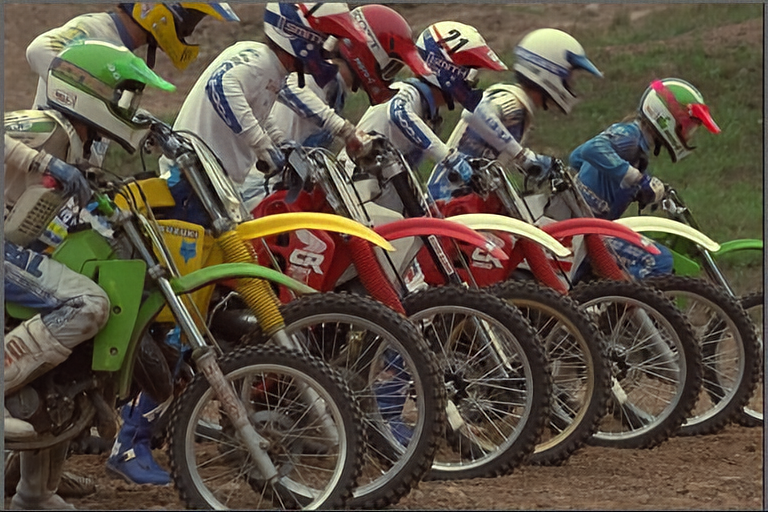

In [4]:
with torch.no_grad():
    codec.eval()
    x = PILToTensor()(img).to(torch.float)
    x = (x/255 - 0.5).unsqueeze(0).to(device)
    x_hat, _, _ = codec(x)
ToPILImage()(x_hat[0]+0.5)

### Accessing latents

In [5]:
with torch.no_grad():
    codec.eval()
    X = codec.wavelet_analysis(x,J=codec.J)
    Y = codec.encoder(X)
    X_hat = codec.decoder(Y)
    x_hat = codec.wavelet_synthesis(X_hat,J=codec.J)

print(f"dimensionality reduction: {x.numel()/Y.numel()}×")

dimensionality reduction: 12.0×


In [6]:
Y.unique()

tensor([-15., -14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,
         -3.,  -2.,  -1.,  -0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
          9.,  10.,  11.,  12.,  13.,  14.,  15.])

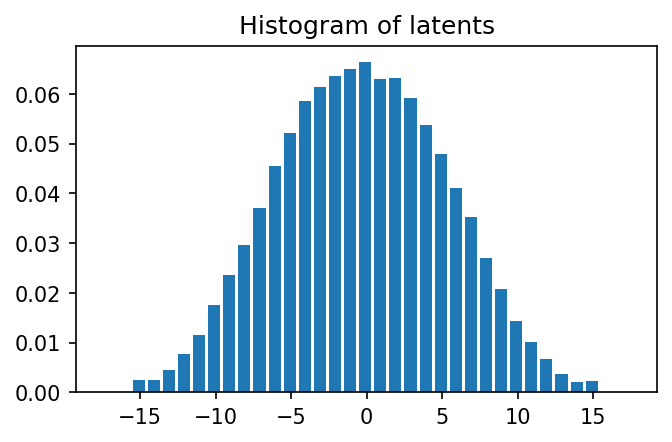

In [7]:
plt.figure(figsize=(5,3),dpi=150)
plt.hist(
    Y.flatten().numpy(),
    range=(-17.5,17.5),
    bins=35,
    density=True,
    width=0.8);
plt.title("Histogram of latents")
plt.xticks(range(-15,16,5));

# Lossless compression of latents using PNG

In [8]:
def concatenate_channels(x):
    batch_size, N, h, w = x.shape
    n = int(N**0.5)
    if n*n != N:
        raise ValueError("Number of channels must be a perfect square.")
    
    x = x.view(batch_size, n, n, h, w)
    x = x.permute(0, 1, 3, 2, 4).contiguous()
    x = x.view(batch_size, 1, n*h, n*w)
    return x

def split_channels(x, N):
    batch_size, _, H, W = x.shape
    n = int(N**0.5)
    h = H // n
    w = W // n
    
    x = x.view(batch_size, n, h, n, w)
    x = x.permute(0, 1, 3, 2, 4).contiguous()
    x = x.view(batch_size, N, h, w)
    return x

def to_bytes(x, n_bits):
    max_value = 2**(n_bits - 1) - 1
    min_value = -max_value - 1
    if x.min() < min_value or x.max() > max_value:
        raise ValueError(f"Tensor values should be in the range [{min_value}, {max_value}].")
    return (x + (max_value + 1)).to(torch.uint8)

def from_bytes(x, n_bits):
    max_value = 2**(n_bits - 1) - 1
    return (x.to(torch.float32) - (max_value + 1))

def latent_to_pil(latent, n_bits):
    latent_bytes = to_bytes(latent, n_bits)
    concatenated_latent = concatenate_channels(latent_bytes)
    
    pil_images = []
    for i in range(concatenated_latent.shape[0]):
        pil_image = Image.fromarray(concatenated_latent[i][0].numpy(), mode='L')
        pil_images.append(pil_image)
    
    return pil_images

def pil_to_latent(pil_images, N, n_bits):
    tensor_images = [PILToTensor()(img).unsqueeze(0) for img in pil_images]
    tensor_images = torch.cat(tensor_images, dim=0)
    split_latent = split_channels(tensor_images, N)
    latent = from_bytes(split_latent, n_bits)
    return latent

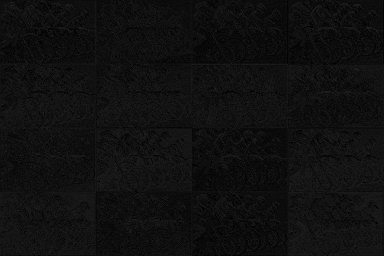

In [9]:
Y_pil = latent_to_pil(Y,5)
Y_pil[0]

In [10]:
Y_pil[0].save('latent.png')
print("compression_ratio: ", x.numel()/os.path.getsize("latent.png"))

compression_ratio:  20.307596963280485


In [11]:
Y2 = pil_to_latent(Y_pil, 16, 5)
(Y == Y2).sum()/Y.numel()

tensor(1.)

In [13]:
!jupyter nbconvert --to markdown README.ipynb

[NbConvertApp] Converting notebook README.ipynb to markdown
[NbConvertApp] Support files will be in README_files/
[NbConvertApp] Making directory README_files
[NbConvertApp] Writing 5751 bytes to README.md
